Siren Detection with CNN + LSTM

In [55]:
# Step 1: Imports
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [56]:
# Step 2: Feature Extraction Function (MFCC + delta + delta-delta)
def extract_features_fixed(file_path, n_mfcc=40, max_len=174):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.vstack([mfcc, delta, delta2])  # Shape: (120, T)

    # Normalize
    features = (features - np.mean(features)) / np.std(features)

    # Pad or truncate to fixed time dimension
    if features.shape[1] < max_len:
        features = np.pad(features, ((0, 0), (0, max_len - features.shape[1])), mode='constant')
    else:
        features = features[:, :max_len]

    return features

def load_dataset(folder, max_len=174):
    data = []
    labels = []
    for label in ['siren', 'non_siren']:
        sub_folder = os.path.join(folder, label)
        for file in os.listdir(sub_folder):
            if file.endswith('.wav'):
                path = os.path.join(sub_folder, file)
                features = extract_features_fixed(path, max_len=max_len)
                data.append(features)
                labels.append(1 if label == 'siren' else 0)
    return np.array(data), np.array(labels)

X, y = load_dataset(r"E:\Campus\Semester\FYP\siren_detection_project\dataset")  # Raw string avoids \ errors
X = X[..., np.newaxis]  # Add channel dimension: (samples, 120, 174, 1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 174, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

c:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# Step 6: Callbacks
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

In [60]:
# Step 7: Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9106 - loss: 0.3968 - val_accuracy: 0.9671 - val_loss: 0.5074 - learning_rate: 1.0000e-04
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.9729 - loss: 0.0934 - val_accuracy: 0.4990 - val_loss: 0.6866 - learning_rate: 1.0000e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9785 - loss: 0.0652 - val_accuracy: 0.6047 - val_loss: 0.7277 - learning_rate: 1.0000e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9817 - loss: 0.0439
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
129/129 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9817 - loss: 0.0440 - val_accuracy: 0.6628 - val_loss: 0.9127 - learning_rate: 1.0000e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9872 - loss: 0.0303 - val_accuracy: 0.7180 - val_loss: 0.8314 - learning_rate: 5.0000e-05
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 

In [61]:
# Step 8: Evaluation
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=['Non-Siren', 'Siren']))

# Optional: Save model
model.save("Model_V6_Hybrid_Improved.h5")

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step



Classification Report:
              precision    recall  f1-score   support

   Non-Siren       0.98      0.96      0.97       534
       Siren       0.95      0.98      0.97       498

    accuracy                           0.97      1032
   macro avg       0.97      0.97      0.97      1032
weighted avg       0.97      0.97      0.97      1032



In [62]:
import pyaudio
import time
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# Load model
model = load_model("Model_V6_Hybrid_Improved.h5")

# Audio settings
CHUNK = 44100  # Try 2-second chunks (44100 samples @ 22050 Hz)
RATE = 22050
FORMAT = pyaudio.paInt16
CHANNELS = 1

# Feature extraction (must match training)
def extract_features(audio, sr=22050, n_mfcc=40, max_len=174):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.vstack([mfcc, delta, delta2])  # Shape: (120, T)
    
    # Normalize (use same scaling as training)
    features = (features - np.mean(features)) / np.std(features)
    
    # Pad/truncate to fixed length
    if features.shape[1] < max_len:
        features = np.pad(features, ((0, 0), (0, max_len - features.shape[1])), mode='constant')
    else:
        features = features[:, :max_len]
    
    return features[..., np.newaxis]  # Shape: (120, 174, 1)

# Start stream
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

print("🎤 Listening... Press Ctrl+C to stop")

try:
    while True:
        audio_data = stream.read(CHUNK, exception_on_overflow=False)
        audio_np = np.frombuffer(audio_data, dtype=np.int16).astype(np.float32)
        audio_np = audio_np / 32768.0  # Normalize to [-1, 1]

        # Skip silent/quiet frames
        max_volume = np.max(np.abs(audio_np))
        if max_volume < 0.01:  # Adjust based on testing
            print("🔇 Too quiet, ignoring")
            time.sleep(0.1)
            continue

        # Extract features and predict
        features = extract_features(audio_np)
        features = np.expand_dims(features, axis=0)  # Shape: (1, 120, 174, 1)
        prediction = model.predict(features, verbose=0)[0][0]
        
        if prediction > 0.9:  # Higher threshold reduces false positives
            print(f"🚨 SIREN DETECTED! (Confidence: {prediction:.2f})")
        else:
            print(f"✅ No Siren (Confidence: {1 - prediction:.2f})")

        time.sleep(0.5)  # Adjust delay between checks

except KeyboardInterrupt:
    print("\n🛑 Stopped by user.")
    stream.stop_stream()
    stream.close()
    p.terminate()

🎤 Listening... Press Ctrl+C to stop
✅ No Siren (Confidence: 0.56)
✅ No Siren (Confidence: 0.55)
✅ No Siren (Confidence: 0.56)
✅ No Siren (Confidence: 0.56)
🔇 Too quiet, ignoring
✅ No Siren (Confidence: 0.56)
✅ No Siren (Confidence: 0.56)
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
✅ No Siren (Confidence: 0.54)
✅ No Siren (Confidence: 0.56)
✅ No Siren (Confidence: 0.55)
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
✅ No Siren (Confidence: 0.56)
🔇 Too quiet, ignoring
✅ No Siren (Confidence: 0.56)
🔇 Too quiet, ignoring
✅ No Siren (Confidence: 0.56)
🔇 Too quiet, ignoring
✅ No Siren (Confidence: 0.56)
✅ No Siren (Confidence: 0.56)
✅ No Siren (Confidence: 0.57)
✅ No Siren (Confidence: 0.56)
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
🔇 Too quiet, ignoring
✅ No Siren (Confidence

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step


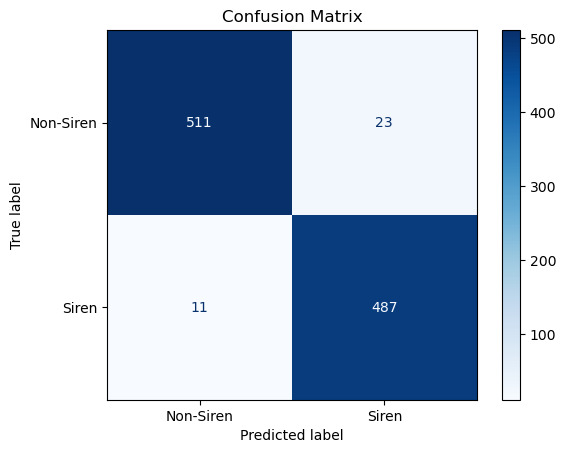

Classification Report:
               precision    recall  f1-score   support

   Non-Siren     0.9789    0.9569    0.9678       534
       Siren     0.9549    0.9779    0.9663       498

    accuracy                         0.9671      1032
   macro avg     0.9669    0.9674    0.9670      1032
weighted avg     0.9673    0.9671    0.9671      1032


Performance Metrics:
Accuracy:  96.71%
Precision: 95.49%
Recall:    97.79%
F1 Score:  96.63%


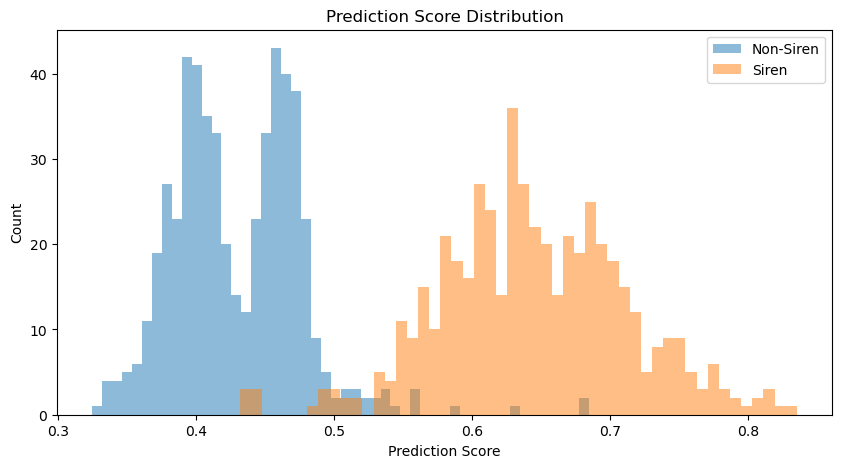

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("Model_V6_Hybrid_Improved.h5")  # Changed to your saved model name

# Since you already have X_test and y_test from your training script, we'll use those
# No need to load from .npy files since you already have them in memory

# Make predictions
y_pred_probs = model.predict(X_test)

# Your model has a single output with sigmoid activation (binary classification)
# So we don't need np.argmax, just threshold at 0.5
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Get true labels (already have y_test from train_test_split)
y_true = y_test

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=['Non-Siren', 'Siren'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# 📈 Classification Report
report = classification_report(y_true, y_pred, 
                             target_names=['Non-Siren', 'Siren'],
                             digits=4)
print("Classification Report:\n", report)

# ✅ Extract Performance Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)  # No average needed for binary
recall = recall_score(y_true, y_pred)       # No average needed for binary
f1 = f1_score(y_true, y_pred)               # No average needed for binary

print(f"\nPerformance Metrics:")
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1 Score:  {f1 * 100:.2f}%")

# Additional: Plot prediction distribution
plt.figure(figsize=(10, 5))
plt.hist(y_pred_probs[y_true == 0], bins=50, alpha=0.5, label='Non-Siren')
plt.hist(y_pred_probs[y_true == 1], bins=50, alpha=0.5, label='Siren')
plt.title("Prediction Score Distribution")
plt.xlabel("Prediction Score")
plt.ylabel("Count")
plt.legend()
plt.show()

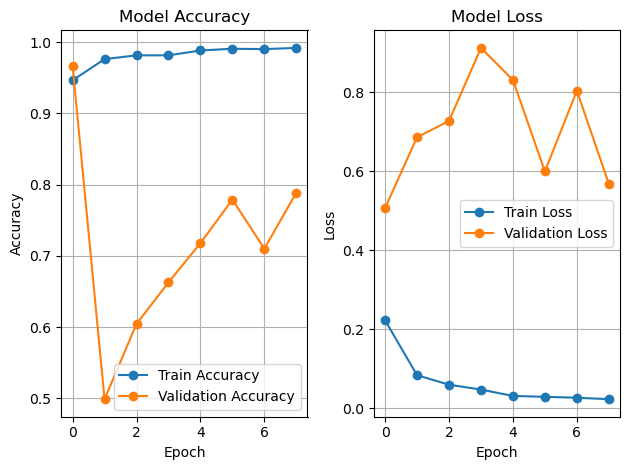

In [64]:
# # Plotting accuracy and loss
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
